In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet

2023-02-01 15:41:18.290967: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
#DATAPATH = '/Users/jiehyun/Jenna/UMassBoston/Research/Nathan_Arnett_Calcification/'
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')


In [4]:
images = np.load(images_file)
labels = np.load(labels_file)

In [5]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [6]:
p = np.random.permutation(len(images))

In [7]:
images = images[p]
labels = labels[p]

In [8]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [9]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [10]:
images.shape

(503, 512, 512, 1)

In [11]:
labels.shape

(503, 512, 512, 1)

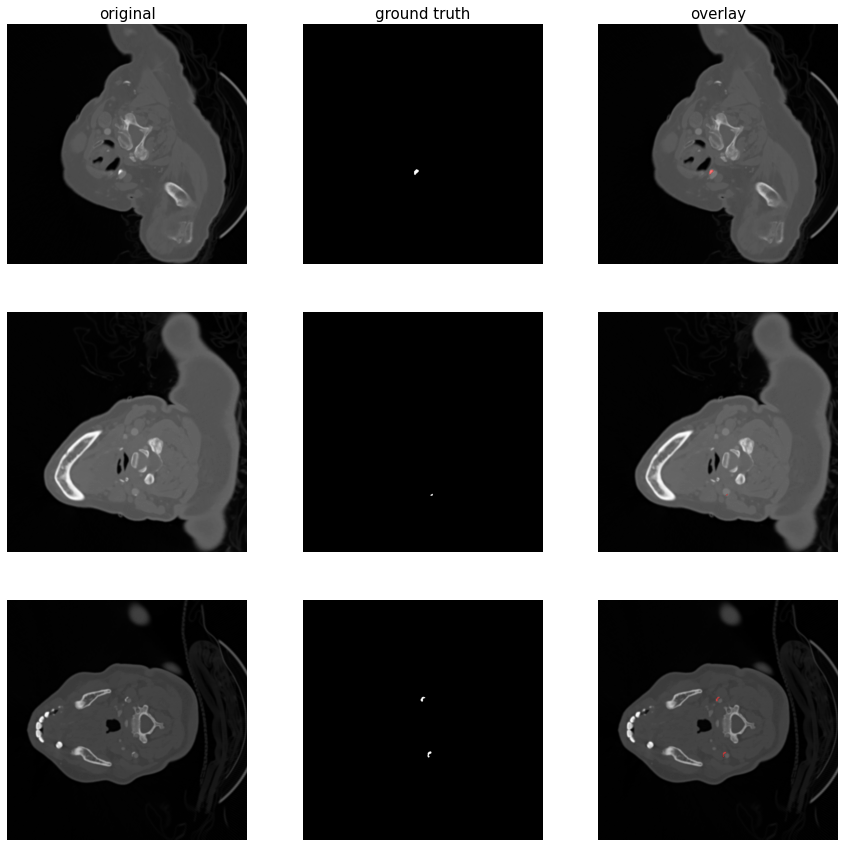

In [12]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [13]:
X_train = images[0:300]
y_train = labels[0:300]
X_val = images[300:400]
y_val = labels[300:400]
X_test = images[400:]
y_test = labels[400:]

In [14]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 4, 4, 4], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-02-01 15:41:38.959526: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-01 15:41:39.055891: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-01 15:41:39.055929: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-01 15:41:39.055961: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-01 15:41:39.055977: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-01 15:41:39.063378: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [15]:
model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 16384, 16)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 16384, 64)    1049664     patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 16384, 64)    83460       patch_embedding[0][0]            
____________________________________________________________________________________

In [16]:
from tensorflow.keras import optimizers
#from tensorflow.keras.optimizers import Adam
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses
#from keras_unet.losses import jaccard_distance

In [17]:
model.compile(loss='binary_crossentropy',
              #loss=jaccard_distance,
              optimizer=optimizers.Adam(lr=1e-3),
              #optimizer = 'Adam',
              metrics=['accuracy', dice_coef, iou, iou_thresholded])

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [18]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=16, 
                    epochs=500,
                    validation_data=(X_val, y_val))

2023-02-01 15:41:55.946598: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-01 15:41:55.965175: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/500


2023-02-01 15:42:20.933579: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-01 15:42:22.258944: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-01 15:42:22.259292: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-01 15:42:22.396303: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-02-01 15:42:22.609322: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-02-01 15:42:23.345257: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-02-01 15:42:23.345281: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-02-01 15:42:23.34563

19/19 [==============================] - 47s 1s/step - loss: 0.1206 - accuracy: 0.9546 - dice_coef: 0.0010 - iou: 9.4808e-04 - iou_thresholded: 0.0010 - val_loss: 0.0079 - val_accuracy: 0.9997 - val_dice_coef: 0.0017 - val_iou: 0.0017 - val_iou_thresholded: 0.0031
Epoch 2/500
19/19 [==============================] - 14s 738ms/step - loss: 0.0050 - accuracy: 0.9998 - dice_coef: 0.0010 - iou: 8.5117e-04 - iou_thresholded: 0.0012 - val_loss: 0.0043 - val_accuracy: 0.9997 - val_dice_coef: 0.0015 - val_iou: 0.0013 - val_iou_thresholded: 0.0031
Epoch 3/500
19/19 [==============================] - 14s 735ms/step - loss: 0.0030 - accuracy: 0.9998 - dice_coef: 0.0013 - iou: 9.4799e-04 - iou_thresholded: 0.0012 - val_loss: 0.0029 - val_accuracy: 0.9997 - val_dice_coef: 0.0018 - val_iou: 0.0014 - val_iou_thresholded: 0.0031
Epoch 4/500
19/19 [==============================] - 14s 736ms/step - loss: 0.0024 - accuracy: 0.9998 - dice_coef: 0.0016 - iou: 0.0012 - iou_thresholded: 0.0012 - val_loss: 0

Epoch 31/500
19/19 [==============================] - 14s 741ms/step - loss: 8.2927e-04 - accuracy: 0.9998 - dice_coef: 0.2197 - iou: 0.1248 - iou_thresholded: 0.1727 - val_loss: 0.0011 - val_accuracy: 0.9998 - val_dice_coef: 0.1990 - val_iou: 0.1134 - val_iou_thresholded: 0.1541
Epoch 32/500
19/19 [==============================] - 14s 735ms/step - loss: 8.4848e-04 - accuracy: 0.9998 - dice_coef: 0.2148 - iou: 0.1227 - iou_thresholded: 0.1646 - val_loss: 0.0014 - val_accuracy: 0.9997 - val_dice_coef: 0.1004 - val_iou: 0.0559 - val_iou_thresholded: 0.0392
Epoch 33/500
19/19 [==============================] - 15s 780ms/step - loss: 8.2365e-04 - accuracy: 0.9998 - dice_coef: 0.2223 - iou: 0.1277 - iou_thresholded: 0.1780 - val_loss: 0.0010 - val_accuracy: 0.9998 - val_dice_coef: 0.2184 - val_iou: 0.1260 - val_iou_thresholded: 0.1414
Epoch 34/500
19/19 [==============================] - 15s 784ms/step - loss: 6.9383e-04 - accuracy: 0.9998 - dice_coef: 0.3069 - iou: 0.1827 - iou_thresholde

Epoch 60/500
19/19 [==============================] - 14s 740ms/step - loss: 2.6545e-04 - accuracy: 0.9999 - dice_coef: 0.6214 - iou: 0.4520 - iou_thresholded: 0.5663 - val_loss: 6.3146e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.4890 - val_iou: 0.3281 - val_iou_thresholded: 0.4030
Epoch 61/500
19/19 [==============================] - 14s 735ms/step - loss: 2.5370e-04 - accuracy: 0.9999 - dice_coef: 0.6368 - iou: 0.4682 - iou_thresholded: 0.5873 - val_loss: 6.2822e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.4976 - val_iou: 0.3347 - val_iou_thresholded: 0.4051
Epoch 62/500
19/19 [==============================] - 14s 738ms/step - loss: 2.4986e-04 - accuracy: 0.9999 - dice_coef: 0.6312 - iou: 0.4633 - iou_thresholded: 0.5797 - val_loss: 6.3242e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.4973 - val_iou: 0.3351 - val_iou_thresholded: 0.3987
Epoch 63/500
19/19 [==============================] - 14s 738ms/step - loss: 2.4417e-04 - accuracy: 0.9999 - dice_coef: 0.6460 - iou: 0.4782 - io

Epoch 89/500
19/19 [==============================] - 14s 740ms/step - loss: 1.2755e-04 - accuracy: 1.0000 - dice_coef: 0.8015 - iou: 0.6692 - iou_thresholded: 0.7895 - val_loss: 7.0958e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.5735 - val_iou: 0.4068 - val_iou_thresholded: 0.4415
Epoch 90/500
19/19 [==============================] - 14s 738ms/step - loss: 1.1409e-04 - accuracy: 1.0000 - dice_coef: 0.8142 - iou: 0.6875 - iou_thresholded: 0.8092 - val_loss: 6.6866e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.5804 - val_iou: 0.4132 - val_iou_thresholded: 0.4540
Epoch 91/500
19/19 [==============================] - 14s 731ms/step - loss: 1.0693e-04 - accuracy: 1.0000 - dice_coef: 0.8234 - iou: 0.7004 - iou_thresholded: 0.8265 - val_loss: 6.7248e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.5890 - val_iou: 0.4212 - val_iou_thresholded: 0.4644
Epoch 92/500
19/19 [==============================] - 14s 744ms/step - loss: 9.9966e-05 - accuracy: 1.0000 - dice_coef: 0.8336 - iou: 0.7152 - io

Epoch 118/500
19/19 [==============================] - 14s 736ms/step - loss: 6.0536e-05 - accuracy: 1.0000 - dice_coef: 0.8952 - iou: 0.8106 - iou_thresholded: 0.9118 - val_loss: 8.0169e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.6110 - val_iou: 0.4446 - val_iou_thresholded: 0.4697
Epoch 119/500
19/19 [==============================] - 14s 740ms/step - loss: 6.1001e-05 - accuracy: 1.0000 - dice_coef: 0.8945 - iou: 0.8096 - iou_thresholded: 0.9093 - val_loss: 8.6263e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.5962 - val_iou: 0.4282 - val_iou_thresholded: 0.4513
Epoch 120/500
19/19 [==============================] - 14s 750ms/step - loss: 5.6784e-05 - accuracy: 1.0000 - dice_coef: 0.8999 - iou: 0.8183 - iou_thresholded: 0.9237 - val_loss: 8.4260e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.6093 - val_iou: 0.4423 - val_iou_thresholded: 0.4640
Epoch 121/500
19/19 [==============================] - 14s 729ms/step - loss: 5.4130e-05 - accuracy: 1.0000 - dice_coef: 0.9039 - iou: 0.8250 

Epoch 147/500
19/19 [==============================] - 14s 733ms/step - loss: 3.2639e-05 - accuracy: 1.0000 - dice_coef: 0.9403 - iou: 0.8875 - iou_thresholded: 0.9681 - val_loss: 9.5939e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.6174 - val_iou: 0.4493 - val_iou_thresholded: 0.4665
Epoch 148/500
19/19 [==============================] - 14s 741ms/step - loss: 4.1866e-05 - accuracy: 1.0000 - dice_coef: 0.9295 - iou: 0.8686 - iou_thresholded: 0.9470 - val_loss: 9.4059e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.6146 - val_iou: 0.4470 - val_iou_thresholded: 0.4668
Epoch 149/500
19/19 [==============================] - 14s 738ms/step - loss: 4.2756e-05 - accuracy: 1.0000 - dice_coef: 0.9268 - iou: 0.8639 - iou_thresholded: 0.9385 - val_loss: 0.0010 - val_accuracy: 0.9998 - val_dice_coef: 0.5996 - val_iou: 0.4325 - val_iou_thresholded: 0.4450
Epoch 150/500
19/19 [==============================] - 14s 745ms/step - loss: 4.8551e-05 - accuracy: 1.0000 - dice_coef: 0.9211 - iou: 0.8541 - io

Epoch 176/500
19/19 [==============================] - 14s 732ms/step - loss: 1.4009e-05 - accuracy: 1.0000 - dice_coef: 0.9703 - iou: 0.9425 - iou_thresholded: 0.9957 - val_loss: 0.0011 - val_accuracy: 0.9998 - val_dice_coef: 0.6238 - val_iou: 0.4567 - val_iou_thresholded: 0.4696
Epoch 177/500
19/19 [==============================] - 14s 739ms/step - loss: 1.3937e-05 - accuracy: 1.0000 - dice_coef: 0.9705 - iou: 0.9427 - iou_thresholded: 0.9959 - val_loss: 0.0011 - val_accuracy: 0.9998 - val_dice_coef: 0.6160 - val_iou: 0.4488 - val_iou_thresholded: 0.4591
Epoch 178/500
19/19 [==============================] - 14s 744ms/step - loss: 1.3856e-05 - accuracy: 1.0000 - dice_coef: 0.9708 - iou: 0.9434 - iou_thresholded: 0.9957 - val_loss: 0.0011 - val_accuracy: 0.9998 - val_dice_coef: 0.6225 - val_iou: 0.4552 - val_iou_thresholded: 0.4633
Epoch 179/500
19/19 [==============================] - 14s 736ms/step - loss: 1.3450e-05 - accuracy: 1.0000 - dice_coef: 0.9713 - iou: 0.9443 - iou_thresh

19/19 [==============================] - 14s 733ms/step - loss: 9.2249e-06 - accuracy: 1.0000 - dice_coef: 0.9809 - iou: 0.9625 - iou_thresholded: 0.9955 - val_loss: 0.0013 - val_accuracy: 0.9998 - val_dice_coef: 0.6144 - val_iou: 0.4476 - val_iou_thresholded: 0.4558
Epoch 206/500
19/19 [==============================] - 14s 740ms/step - loss: 8.9865e-06 - accuracy: 1.0000 - dice_coef: 0.9814 - iou: 0.9636 - iou_thresholded: 0.9957 - val_loss: 0.0013 - val_accuracy: 0.9998 - val_dice_coef: 0.6227 - val_iou: 0.4556 - val_iou_thresholded: 0.4676
Epoch 207/500
19/19 [==============================] - 14s 731ms/step - loss: 8.8914e-06 - accuracy: 1.0000 - dice_coef: 0.9815 - iou: 0.9638 - iou_thresholded: 0.9952 - val_loss: 0.0013 - val_accuracy: 0.9998 - val_dice_coef: 0.6192 - val_iou: 0.4523 - val_iou_thresholded: 0.4603
Epoch 208/500
19/19 [==============================] - 14s 748ms/step - loss: 8.5649e-06 - accuracy: 1.0000 - dice_coef: 0.9820 - iou: 0.9647 - iou_thresholded: 0.9965 

Epoch 234/500
19/19 [==============================] - 14s 732ms/step - loss: 4975.6489 - accuracy: 0.9983 - dice_coef: 0.0013 - iou: 0.0012 - iou_thresholded: 0.0012 - val_loss: 14165.9297 - val_accuracy: 0.9997 - val_dice_coef: 0.0031 - val_iou: 0.0031 - val_iou_thresholded: 0.0031
Epoch 235/500
19/19 [==============================] - 14s 738ms/step - loss: 5592.7925 - accuracy: 0.9994 - dice_coef: 0.0011 - iou: 0.0011 - iou_thresholded: 0.0011 - val_loss: 1067.7974 - val_accuracy: 0.9997 - val_dice_coef: 0.0031 - val_iou: 0.0031 - val_iou_thresholded: 0.0031
Epoch 236/500
19/19 [==============================] - 14s 740ms/step - loss: 616.4180 - accuracy: 0.9986 - dice_coef: 0.0011 - iou: 9.6824e-04 - iou_thresholded: 9.6826e-04 - val_loss: 917.3143 - val_accuracy: 0.9997 - val_dice_coef: 0.0031 - val_iou: 0.0031 - val_iou_thresholded: 0.0031
Epoch 237/500
19/19 [==============================] - 14s 735ms/step - loss: 996.7487 - accuracy: 0.9997 - dice_coef: 0.0012 - iou: 0.0012 -

Epoch 263/500
19/19 [==============================] - 14s 736ms/step - loss: 4.6577 - accuracy: 0.9991 - dice_coef: 0.0082 - iou: 0.0043 - iou_thresholded: 0.0043 - val_loss: 5.5459 - val_accuracy: 0.9994 - val_dice_coef: 0.0077 - val_iou: 0.0042 - val_iou_thresholded: 0.0042
Epoch 264/500
19/19 [==============================] - 14s 752ms/step - loss: 4.2061 - accuracy: 0.9992 - dice_coef: 0.0078 - iou: 0.0041 - iou_thresholded: 0.0041 - val_loss: 5.0495 - val_accuracy: 0.9987 - val_dice_coef: 0.0156 - val_iou: 0.0080 - val_iou_thresholded: 0.0080
Epoch 265/500
19/19 [==============================] - 14s 736ms/step - loss: 3.7086 - accuracy: 0.9992 - dice_coef: 0.0101 - iou: 0.0052 - iou_thresholded: 0.0052 - val_loss: 4.6321 - val_accuracy: 0.9989 - val_dice_coef: 0.0124 - val_iou: 0.0064 - val_iou_thresholded: 0.0064
Epoch 266/500
19/19 [==============================] - 14s 741ms/step - loss: 3.4415 - accuracy: 0.9993 - dice_coef: 0.0122 - iou: 0.0063 - iou_thresholded: 0.0063 - 

19/19 [==============================] - 14s 736ms/step - loss: 1.4281 - accuracy: 0.9993 - dice_coef: 0.0165 - iou: 0.0085 - iou_thresholded: 0.0085 - val_loss: 2.0592 - val_accuracy: 0.9990 - val_dice_coef: 0.0145 - val_iou: 0.0075 - val_iou_thresholded: 0.0075
Epoch 293/500
19/19 [==============================] - 16s 836ms/step - loss: 1.3691 - accuracy: 0.9993 - dice_coef: 0.0193 - iou: 0.0100 - iou_thresholded: 0.0100 - val_loss: 2.0932 - val_accuracy: 0.9989 - val_dice_coef: 0.0152 - val_iou: 0.0078 - val_iou_thresholded: 0.0078
Epoch 294/500
19/19 [==============================] - 14s 744ms/step - loss: 1.3414 - accuracy: 0.9994 - dice_coef: 0.0152 - iou: 0.0079 - iou_thresholded: 0.0079 - val_loss: 2.1418 - val_accuracy: 0.9995 - val_dice_coef: 0.0097 - val_iou: 0.0053 - val_iou_thresholded: 0.0053
Epoch 295/500
19/19 [==============================] - 14s 734ms/step - loss: 1.2469 - accuracy: 0.9993 - dice_coef: 0.0153 - iou: 0.0079 - iou_thresholded: 0.0079 - val_loss: 1.85

19/19 [==============================] - 14s 740ms/step - loss: 0.6568 - accuracy: 0.9995 - dice_coef: 0.0119 - iou: 0.0063 - iou_thresholded: 0.0062 - val_loss: 1.0149 - val_accuracy: 0.9995 - val_dice_coef: 0.0119 - val_iou: 0.0064 - val_iou_thresholded: 0.0063
Epoch 322/500
19/19 [==============================] - 14s 739ms/step - loss: 0.6147 - accuracy: 0.9995 - dice_coef: 0.0110 - iou: 0.0058 - iou_thresholded: 0.0058 - val_loss: 1.0527 - val_accuracy: 0.9995 - val_dice_coef: 0.0104 - val_iou: 0.0057 - val_iou_thresholded: 0.0057
Epoch 323/500
19/19 [==============================] - 14s 739ms/step - loss: 0.5850 - accuracy: 0.9995 - dice_coef: 0.0107 - iou: 0.0057 - iou_thresholded: 0.0057 - val_loss: 0.9371 - val_accuracy: 0.9994 - val_dice_coef: 0.0125 - val_iou: 0.0066 - val_iou_thresholded: 0.0066
Epoch 324/500
19/19 [==============================] - 14s 741ms/step - loss: 0.5657 - accuracy: 0.9995 - dice_coef: 0.0123 - iou: 0.0064 - iou_thresholded: 0.0065 - val_loss: 0.93

19/19 [==============================] - 14s 733ms/step - loss: 0.3301 - accuracy: 0.9995 - dice_coef: 0.0143 - iou: 0.0075 - iou_thresholded: 0.0075 - val_loss: 0.6013 - val_accuracy: 0.9994 - val_dice_coef: 0.0098 - val_iou: 0.0053 - val_iou_thresholded: 0.0053
Epoch 351/500
19/19 [==============================] - 14s 732ms/step - loss: 0.3351 - accuracy: 0.9995 - dice_coef: 0.0110 - iou: 0.0058 - iou_thresholded: 0.0058 - val_loss: 0.6070 - val_accuracy: 0.9995 - val_dice_coef: 0.0086 - val_iou: 0.0048 - val_iou_thresholded: 0.0048
Epoch 352/500
19/19 [==============================] - 14s 751ms/step - loss: 0.3123 - accuracy: 0.9996 - dice_coef: 0.0125 - iou: 0.0066 - iou_thresholded: 0.0066 - val_loss: 0.6417 - val_accuracy: 0.9994 - val_dice_coef: 0.0128 - val_iou: 0.0068 - val_iou_thresholded: 0.0067
Epoch 353/500
19/19 [==============================] - 14s 733ms/step - loss: 0.3489 - accuracy: 0.9995 - dice_coef: 0.0136 - iou: 0.0071 - iou_thresholded: 0.0071 - val_loss: 0.62

19/19 [==============================] - 14s 733ms/step - loss: 0.1647 - accuracy: 0.9996 - dice_coef: 0.0188 - iou: 0.0098 - iou_thresholded: 0.0098 - val_loss: 0.3871 - val_accuracy: 0.9995 - val_dice_coef: 0.0100 - val_iou: 0.0055 - val_iou_thresholded: 0.0054
Epoch 380/500
19/19 [==============================] - 14s 742ms/step - loss: 0.1616 - accuracy: 0.9996 - dice_coef: 0.0182 - iou: 0.0095 - iou_thresholded: 0.0095 - val_loss: 0.4065 - val_accuracy: 0.9995 - val_dice_coef: 0.0113 - val_iou: 0.0061 - val_iou_thresholded: 0.0061
Epoch 381/500
19/19 [==============================] - 14s 742ms/step - loss: 0.1926 - accuracy: 0.9996 - dice_coef: 0.0166 - iou: 0.0087 - iou_thresholded: 0.0087 - val_loss: 0.4007 - val_accuracy: 0.9995 - val_dice_coef: 0.0084 - val_iou: 0.0048 - val_iou_thresholded: 0.0048
Epoch 382/500
19/19 [==============================] - 14s 736ms/step - loss: 0.1938 - accuracy: 0.9996 - dice_coef: 0.0145 - iou: 0.0076 - iou_thresholded: 0.0076 - val_loss: 0.43

19/19 [==============================] - 14s 746ms/step - loss: 0.1031 - accuracy: 0.9996 - dice_coef: 0.0185 - iou: 0.0096 - iou_thresholded: 0.0096 - val_loss: 0.2941 - val_accuracy: 0.9995 - val_dice_coef: 0.0120 - val_iou: 0.0065 - val_iou_thresholded: 0.0065
Epoch 409/500
19/19 [==============================] - 14s 724ms/step - loss: 0.1056 - accuracy: 0.9996 - dice_coef: 0.0172 - iou: 0.0090 - iou_thresholded: 0.0089 - val_loss: 0.3153 - val_accuracy: 0.9995 - val_dice_coef: 0.0122 - val_iou: 0.0066 - val_iou_thresholded: 0.0067
Epoch 410/500
19/19 [==============================] - 14s 746ms/step - loss: 0.1011 - accuracy: 0.9996 - dice_coef: 0.0203 - iou: 0.0105 - iou_thresholded: 0.0105 - val_loss: 0.2952 - val_accuracy: 0.9995 - val_dice_coef: 0.0128 - val_iou: 0.0069 - val_iou_thresholded: 0.0070
Epoch 411/500
19/19 [==============================] - 14s 739ms/step - loss: 0.1004 - accuracy: 0.9996 - dice_coef: 0.0181 - iou: 0.0094 - iou_thresholded: 0.0094 - val_loss: 0.35

19/19 [==============================] - 14s 735ms/step - loss: 0.0835 - accuracy: 0.9995 - dice_coef: 0.0173 - iou: 0.0090 - iou_thresholded: 0.0090 - val_loss: 0.2379 - val_accuracy: 0.9996 - val_dice_coef: 0.0100 - val_iou: 0.0057 - val_iou_thresholded: 0.0057
Epoch 438/500
19/19 [==============================] - 14s 747ms/step - loss: 0.0735 - accuracy: 0.9996 - dice_coef: 0.0203 - iou: 0.0105 - iou_thresholded: 0.0106 - val_loss: 0.2222 - val_accuracy: 0.9995 - val_dice_coef: 0.0129 - val_iou: 0.0071 - val_iou_thresholded: 0.0070
Epoch 439/500
19/19 [==============================] - 14s 742ms/step - loss: 0.0713 - accuracy: 0.9996 - dice_coef: 0.0190 - iou: 0.0099 - iou_thresholded: 0.0099 - val_loss: 0.2169 - val_accuracy: 0.9996 - val_dice_coef: 0.0123 - val_iou: 0.0068 - val_iou_thresholded: 0.0068
Epoch 440/500
19/19 [==============================] - 14s 739ms/step - loss: 0.0682 - accuracy: 0.9996 - dice_coef: 0.0216 - iou: 0.0112 - iou_thresholded: 0.0112 - val_loss: 0.20

19/19 [==============================] - 14s 744ms/step - loss: 0.0464 - accuracy: 0.9996 - dice_coef: 0.0281 - iou: 0.0146 - iou_thresholded: 0.0147 - val_loss: 0.1914 - val_accuracy: 0.9996 - val_dice_coef: 0.0103 - val_iou: 0.0057 - val_iou_thresholded: 0.0058
Epoch 467/500
19/19 [==============================] - 14s 733ms/step - loss: 0.0451 - accuracy: 0.9996 - dice_coef: 0.0342 - iou: 0.0177 - iou_thresholded: 0.0178 - val_loss: 0.1733 - val_accuracy: 0.9996 - val_dice_coef: 0.0123 - val_iou: 0.0068 - val_iou_thresholded: 0.0068
Epoch 468/500
19/19 [==============================] - 14s 742ms/step - loss: 0.0505 - accuracy: 0.9996 - dice_coef: 0.0294 - iou: 0.0152 - iou_thresholded: 0.0152 - val_loss: 0.1663 - val_accuracy: 0.9994 - val_dice_coef: 0.0139 - val_iou: 0.0074 - val_iou_thresholded: 0.0074
Epoch 469/500
19/19 [==============================] - 14s 735ms/step - loss: 0.0473 - accuracy: 0.9996 - dice_coef: 0.0282 - iou: 0.0146 - iou_thresholded: 0.0146 - val_loss: 0.17

19/19 [==============================] - 14s 743ms/step - loss: 8.4822 - accuracy: 0.9996 - dice_coef: 0.0042 - iou: 0.0024 - iou_thresholded: 0.0024 - val_loss: 8.3503 - val_accuracy: 0.9995 - val_dice_coef: 0.0066 - val_iou: 0.0036 - val_iou_thresholded: 0.0036
Epoch 496/500
19/19 [==============================] - 15s 804ms/step - loss: 6.2583 - accuracy: 0.9995 - dice_coef: 0.0034 - iou: 0.0020 - iou_thresholded: 0.0020 - val_loss: 6.4982 - val_accuracy: 0.9995 - val_dice_coef: 0.0059 - val_iou: 0.0033 - val_iou_thresholded: 0.0033
Epoch 497/500
19/19 [==============================] - 14s 734ms/step - loss: 4.7451 - accuracy: 0.9996 - dice_coef: 0.0043 - iou: 0.0025 - iou_thresholded: 0.0025 - val_loss: 5.0927 - val_accuracy: 0.9994 - val_dice_coef: 0.0069 - val_iou: 0.0038 - val_iou_thresholded: 0.0038
Epoch 498/500
19/19 [==============================] - 14s 751ms/step - loss: 3.5898 - accuracy: 0.9994 - dice_coef: 0.0041 - iou: 0.0023 - iou_thresholded: 0.0023 - val_loss: 4.06

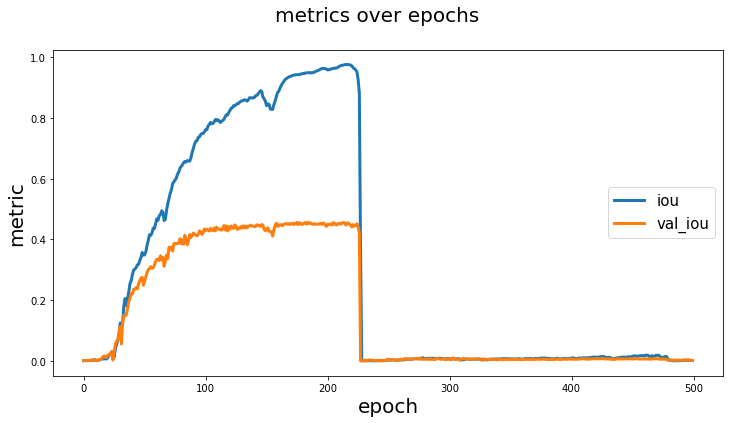

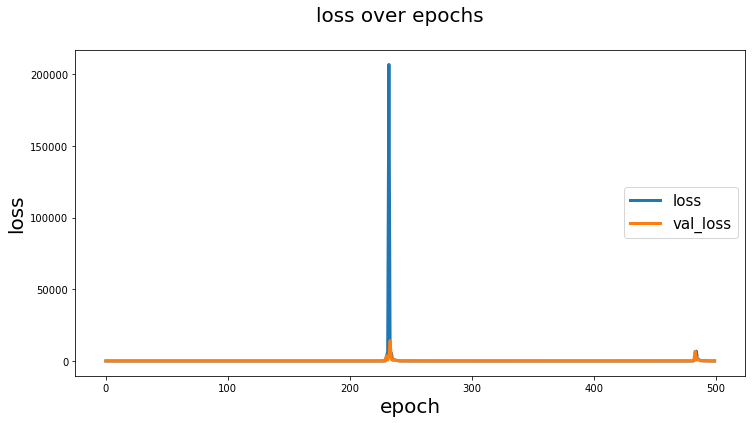

In [19]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [20]:
y_pred = model.predict(X_test)

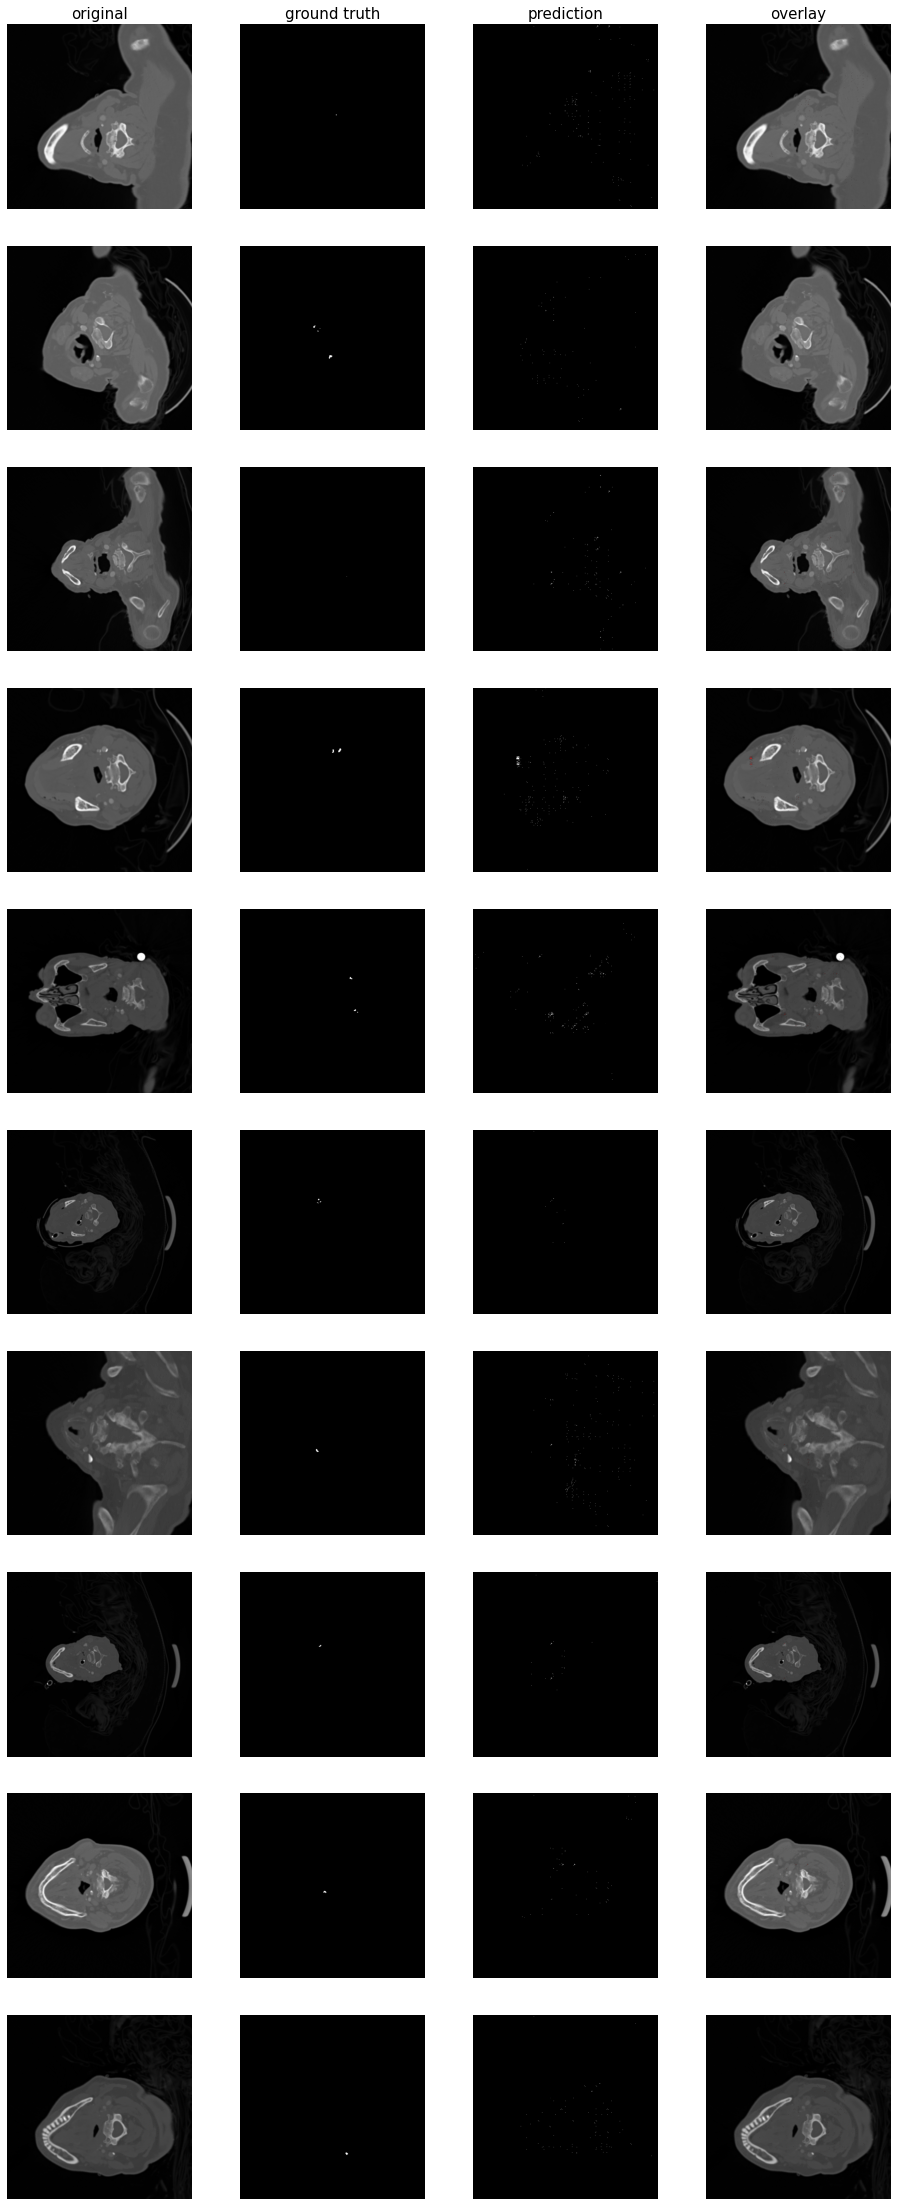

In [21]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)

In [22]:
loss, iou, iou_thresholded = model.evaluate(X_test, y_test)

4/4 [==============================] - 2s 360ms/step - loss: 2.7585 - accuracy: 0.9994 - dice_coef: 0.0016 - iou: 0.0010 - iou_thresholded: 9.8739e-04


ValueError: too many values to unpack (expected 3)